The number of timesteps is 98


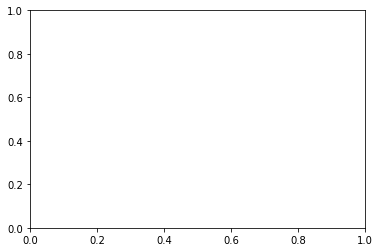

In [2]:
import pdb
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb
import scipy
from scipy.optimize import minimize, rosen, rosen_der


%matplotlib inline

DATA_FILE = "exportUSLab.csv" # Points to the data Katie gave us
VISUALIZE = False
ALARM_THRESHOLD = 2e-20
BIG_NUMBER = 100

all_points = [[]] # This is a doubly-nested list with each internal list representing a single timestep

with open(DATA_FILE, 'r') as infile: # read through line by line and parse by the time
    for line in infile:
        if "symmetry" in line:
            all_points.append([line])
        all_points[-1].append(line)  
       
print("The number of timesteps is {}".format(len(all_points)))

plt.cla()

all_times = []
max_consentrations = []
for time in all_points[1:-1]: #only do a few at the end for speed reasons
    df = pd.read_csv(io.StringIO('\n'.join(time[4:])))#
    df = df.rename(columns={'Node Number': 'N',
                  ' X [ m ]' : 'X',
                  ' Y [ m ]' : 'Y',
                  ' Z [ m ]' : 'Z',
                  ' Particle Mass Concentration [ kg m^-3 ]' : 'C'})
    all_times.append(df)
    consentration = df['C'].values[0:-1] # get all of the consentrations but the null last one
    max_consentrations.append(np.max(consentration))

if VISUALIZE:
    print(max_consentrations)
    max_consentration = max(max_consentrations)
    print(max_consentration)
    
    for i, df in enumerate(all_times): 
    
        plt.cla()
        plt.clf()
        plt.xlabel("X position")
        plt.ylabel("Y position")
        plt.title("consentration at timestep {} versus position".format(i))
        norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
        cb = plt.scatter(df['X'], df['Y'], c=df['C'] / max_consentration, cmap=plt.cm.inferno, norm=norm)
        plt.colorbar(cb) # Add a colorbar to a plot
        plt.savefig("vis/consentration{:03d}.png".format(i))

So the next thing we want to do is convert the output to a 2d space

There are 96 timesteps and 2666 flattened locations
There are 96 timesteps and 2666 flattened locations


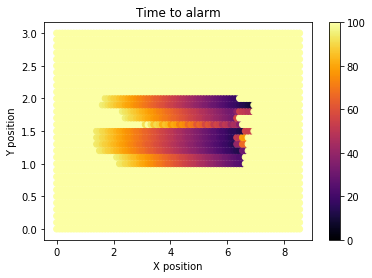

In [3]:
def get_time_to_alarm(X, Y, all_times, flip_x=False, flip_y=False):
    """The flips are just for data augmentation to create more example data
    """
    consentrations = np.asarray([x['C'].values[:-1] for x in all_times]) # Get all of the consentrations 
    print("There are {} timesteps and {} flattened locations".format(consentrations.shape[0], consentrations.shape[1])) 

    alarmed = consentrations > 2 * ALARM_THRESHOLD
    nonzero = np.nonzero(alarmed)
    nonzero_times, nonzero_locations = nonzero # this is pairs indicating that it alarmed at that time and location

    time_to_alarm = []
    for loc in range(alarmed.shape[1] + 1): # All of the possible locations
        same = loc == nonzero_locations
        if(np.any(same)):
            alarmed_times = nonzero_times[same]
            #print("alarmed times {} at location {}".format(alarmed_times, loc))
            #print("first alarmed times is {} at location {}".format(min(alarmed_times), loc))
            time_to_alarm.append(min(alarmed_times))
        else:
            time_to_alarm.append(BIG_NUMBER)


    X = np.array(X.values[:-1]) # The last one is nan for some reason
    Y = np.array(Y.values[:-1])
    time_to_alarm = np.array(time_to_alarm[:-1])
    if flip_x:
        X = max(X) - X + min(X)
    if flip_y:
        Y = max(Y) - Y + min(Y)

    plt.cla()
    plt.clf()
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.title("Time to alarm")
    norm = mpl.colors.Normalize(vmin=0, vmax=BIG_NUMBER)
    cb = plt.scatter(X, Y, c=time_to_alarm, cmap=plt.cm.inferno, norm=norm)
    plt.colorbar(cb) # Add a colorbar to a plot
    return (X, Y, time_to_alarm)
    
X1, Y1, time_to_alarm1 = get_time_to_alarm(df["X"], df["Y"], all_times, False)
X2, Y2, time_to_alarm2 = get_time_to_alarm(df["X"], df["Y"], all_times, True)

In [10]:
#
#from scipy import interpolate
def make_lookup(X, Y, time_to_alarm):
    """Returns a function which searches 
    the data at the sample nearest a given point
    """
    best = np.argmin(time_to_alarm) # get the location of the shortest time to alarm
    XY = np.vstack((X,Y)).transpose() # combine the x and y data points
    print("The best time, determined by exaustive search, is {} and occurs at {}".format(time_to_alarm[best], XY[best,:]))
    EPSILON = 0.00000001
    def ret_func(xy): # this is what will be returned
        diff = xy - XY # get the x and y distances from the query point for each marked point
        dist = np.linalg.norm(diff, axis=1)
        locs = np.argsort(dist)[:4]
        weights = 1.0 / (dist[locs] + EPSILON) # weight by one over the distance to the sample point
        reweighted = weights * time_to_alarm[locs]
        closest_time = sum(reweighted) / sum(weights)
        #f = interpolate.interp2d(X, Y, time_to_alarm)
        return closest_time
    return ret_func

def make_total_lookup_function(xytimes):
    """
    This takes as input a list of tuples in the form [(x, y, times), (x, y, times), ....] coresponding to the different smokes sources
    it returns a function mapping [x1, y1, x2, y2, ....], represnting the x, y coordinates of each detector,to the objective function value
    """
    funcs = []
    for x, y, times in xytimes:
        funcs.append(make_lookup(x, y, times))
    def ret_func(xys):
        all_times = [] # each internal list coresponds to a smoke detector location
        for i in range(0, len(xys), 2):
            all_times.append([])
            x = xys[i]
            y = xys[i+1]
            for func in funcs:
                all_times[-1].append(func([x,y]))
        print("all of the times are {}".format(all_times))
        #                     np.amax([np.amin([f(x) for x in xs]) for f in functions])
        # Take the min over all locations then max over all sources
        all_times = np.asarray(all_times)
        time_for_each_source = np.amin(all_times, axis = 0)
        print("The quickest detction for each source is {}".format(time_for_each_source))
        worst_source = np.amax(time_for_each_source)
        print("The slowest-to-be-detected source takes {}".format(worst_source))
    return ret_func

ret_func = make_lookup(X1, Y1, time_to_alarm1)
#BEST_LOC = np.array([2.31082344, 1.70000005])
#BAD_LOC = np.array([2, 2])

total_ret_func = make_total_lookup_function([(X1, Y1, time_to_alarm1), (X2, Y2, time_to_alarm2)])
total_ret_func([1.70799994, 1.89999998, max(X1) - 1.70799994, 1.89999998])

The best time, determined by exaustive search, is 10 and occurs at [1.70799994 1.89999998]
The best time, determined by exaustive search, is 10 and occurs at [1.70799994 1.89999998]
The best time, determined by exaustive search, is 10 and occurs at [6.83200002 1.89999998]
all of the times are [[10.000021857838034, 94.00001002334811], [94.00001002334808, 10.000021857838034]]
The quickest detction for each source is [10.00002186 10.00002186]
The slowest-to-be-detected source takes 10.000021857838034


In [11]:

BOUNDS = ((0,8),(0, 3)) # constraints on inputs
INIT = (4,1.25)
INIT = (1.70799994 + 0.1, 1.89999998)
res = minimize(ret_func, INIT, method='SLSQP', bounds=BOUNDS)
print(res)


     fun: 11.000292180230804
     jac: array([-851.16352892, -899.89188159])
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.80847074, 1.89999981])
